# 03_features
Feature engineering for weatherization adoption

Target summary:
count     18496.000000
mean      10848.818722
std        7111.765122
min          42.010000
25%        5921.970000
50%        9346.435000
75%       14155.327500
max      184101.840000
Name: KWH, dtype: float64


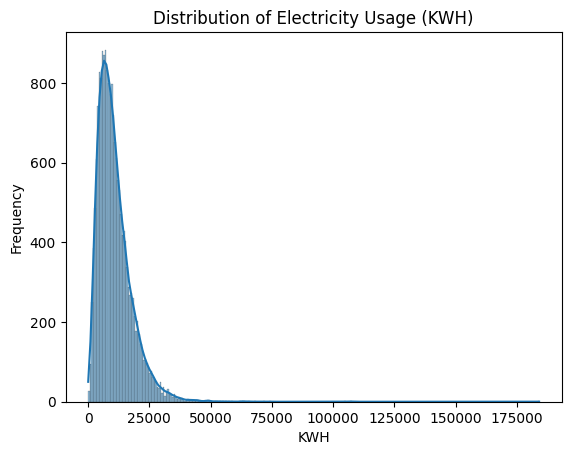

In [9]:
import pandas as pd
import sagemaker
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load full dataset from S3
sess   = sagemaker.Session()
bucket = sess.default_bucket()
key    = "recs/recs2020.csv"
uri    = f"s3://{bucket}/{key}"
df     = pd.read_csv(uri, low_memory=False)

# 2) Define regression target: Annual electricity usage in kWh
target_col = "KWH"
df = df[df[target_col].notna()]  # drop rows without KWH

# 3) Drop identifier, target, and potential leakage columns
X = df.drop(columns=["DOEID", target_col], errors="ignore")
y = df[target_col]

print("Target summary:")
print(y.describe())             # mean, std, min/max, quartiles

# 3) Plot a quick histogram (optional)
%matplotlib inline
# y.hist(bins=50, figsize=(6,3))

sns.histplot(y, kde=True)
plt.title("Distribution of Electricity Usage (KWH)")
plt.xlabel("KWH")
plt.ylabel("Frequency")
plt.show()

In [10]:
print(X.dtypes.value_counts())


int64      548
float64    242
object       7
Name: count, dtype: int64


In [11]:
# 4) Identify numeric and categorical columns
X_num = X.select_dtypes(include=["int64", "float64"])
X_cat = X.select_dtypes(include=["object", "category"])

# 5) Encode categoricals with one-hot (can be sparse)
X_cat_encoded = pd.get_dummies(X_cat, drop_first=True)

# 6) Combine into final feature matrix (missing values allowed)
X_processed = pd.concat([X_num, X_cat_encoded], axis=1)

In [12]:
# Define leakage-related keywords
leakage_terms = ["KWH", "BTUEL", "DOLEL", "TOTALDOL", "DOLLAREL"]

# Identify columns suspected of leakage (excluding the target)
leakage_cols = [
    col for col in X_processed.columns
    if any(term in col for term in leakage_terms) and col != target_col
]

# Print the list and count
print("📌 Filtered columns due to potential leakage:\n")
for col in leakage_cols:
    print("-", col)

print(f"\n🔢 Total filtered columns: {len(leakage_cols)}")

# 2. Drop columns that contain any of these terms (but keep the target)
X_filtered = X_processed.drop(
    columns=[col for col in X_processed.columns if any(term in col for term in leakage_terms) and col != target_col]
)
print("Final feature shape:", X_filtered.shape)

📌 Filtered columns due to potential leakage:

- BTUEL
- DOLLAREL
- KWHSPH
- KWHCOL
- KWHWTH
- KWHRFG
- KWHRFG1
- KWHRFG2
- KWHFRZ
- KWHCOK
- KWHMICRO
- KWHCW
- KWHCDR
- KWHDWH
- KWHLGT
- KWHTVREL
- KWHTV1
- KWHTV2
- KWHTV3
- KWHAHUHEAT
- KWHAHUCOL
- KWHCFAN
- KWHDHUM
- KWHHUM
- KWHPLPMP
- KWHHTBPMP
- KWHHTBHEAT
- KWHEVCHRG
- KWHNEC
- KWHOTH
- BTUELSPH
- BTUELCOL
- BTUELWTH
- BTUELRFG
- BTUELRFG1
- BTUELRFG2
- BTUELFRZ
- BTUELCOK
- BTUELMICRO
- BTUELCW
- BTUELCDR
- BTUELDWH
- BTUELLGT
- BTUELTVREL
- BTUELTV1
- BTUELTV2
- BTUELTV3
- BTUELAHUHEAT
- BTUELAHUCOL
- BTUELCFAN
- BTUELDHUM
- BTUELHUM
- BTUELPLPMP
- BTUELHTBPMP
- BTUELHTBHEAT
- BTUELEVCHRG
- BTUELNEC
- BTUELOTH
- DOLELSPH
- DOLELCOL
- DOLELWTH
- DOLELRFG
- DOLELRFG1
- DOLELRFG2
- DOLELFRZ
- DOLELCOK
- DOLELMICRO
- DOLELCW
- DOLELCDR
- DOLELDWH
- DOLELLGT
- DOLELTVREL
- DOLELTV1
- DOLELTV2
- DOLELTV3
- DOLELAHUHEAT
- DOLELAHUCOL
- DOLELCFAN
- DOLELDHUM
- DOLELHUM
- DOLELPLPMP
- DOLELHTBPMP
- DOLELHTBHEAT
- DOLELEVCHRG
- DOLELNEC


/opt/conda/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


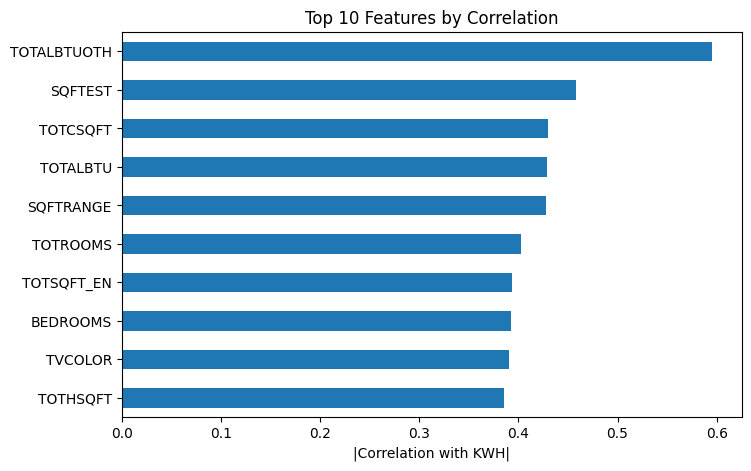

In [13]:
# Compute the correlation of each column in X_filtered with the target y
corr_with_target = X_filtered.apply(lambda col: col.corr(y))

# Pick the top 10 absolute correlations (and keep the sign if you like)
top10 = corr_with_target\
    .abs()\
    .sort_values(ascending=False)\
    .head(10)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
top10.plot.barh()
plt.gca().invert_yaxis()      # highest on top
plt.xlabel("|Correlation with KWH|")
plt.title("Top 10 Features by Correlation")
plt.show()




In [14]:
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42
)

In [15]:
# Save to CSV or Parquet
X_train.to_parquet("X_train.parquet", index=False)
X_test.to_parquet("X_test.parquet", index=False)
y_train.to_frame().to_parquet("y_train.parquet", index=False)
y_test.to_frame().to_parquet("y_test.parquet", index=False)

# Upload to S3
sess.upload_data("X_train.parquet", bucket=bucket, key_prefix="recs/train")
sess.upload_data("X_test.parquet", bucket=bucket, key_prefix="recs/test")
sess.upload_data("y_train.parquet", bucket=bucket, key_prefix="recs/train")
sess.upload_data("y_test.parquet", bucket=bucket, key_prefix="recs/test")

print("✅ Train/test splits saved to S3.")

✅ Train/test splits saved to S3.
